In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train=pd.read_csv("domaci2_data/train.csv")
test=pd.read_csv("domaci2_data/test.csv")
submission=pd.read_csv("domaci2_data/gender_submission.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [6]:
from scipy.stats import zscore

def detect_outliers(df, threshold, features):
    z_scores = np.abs(zscore(df[features]))
    outliers_mask = (z_scores > threshold).any(axis=1)
    outliers_indices = df[outliers_mask].index.tolist()

    return outliers_indices

outliers_to_drop = detect_outliers(train, 5, ["Age", "SibSp", "Parch", "Fare"])
print("DROP indices:", len(outliers_to_drop), outliers_to_drop)


DROP indices: 16 [13, 25, 159, 180, 201, 258, 324, 610, 638, 678, 679, 737, 792, 846, 863, 885]


In [7]:
print("BEFORE: {}".format(len(train)))
train=train.drop(outliers_to_drop,axis=0).reset_index(drop=True)
print("AFTER: {}".format(len(train)))

BEFORE: 891
AFTER: 875


In [8]:
# Analiza kategorickih vrednosti (Sex, Pclass)
atributi = ["Sex", "Pclass", "Embarked"]
for i in atributi:
    print(train[[i, "Survived"]].groupby(i, as_index=False).mean().sort_values(by="Survived", ascending=False))
    print("\n")
# Zakljucujemo da su zene i bogatiji i osobe iz lokacije C cesce prezivljaval

      Sex  Survived
0  female  0.757377
1    male  0.187719


   Pclass  Survived
0       1  0.624413
1       2  0.472826
2       3  0.246862


  Embarked  Survived
0        C  0.545455
1        Q  0.394737
2        S  0.341772




In [9]:
# Broj osoba u kategorickim vrednostima, po kategorijama
for i in atributi:
    print(train[i].value_counts(dropna=False))
# Vise muskaraca, vise siromasnijih, najvise osoba iz lokacije S

Sex
male      570
female    305
Name: count, dtype: int64
Pclass
3    478
1    213
2    184
Name: count, dtype: int64
Embarked
S      632
C      165
Q       76
NaN      2
Name: count, dtype: int64


In [10]:
train.isnull().sum()
#moram se otarasiti Embarked nula i Cabin nula

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          673
Embarked         2
dtype: int64

In [11]:
#Trazim najzastupljeniji od S, C, Q vrednosti
train["Embarked"].value_counts()

Embarked
S    632
C    165
Q     76
Name: count, dtype: int64

In [12]:
mode='S'
train["Embarked"].fillna(mode, inplace=True)

In [13]:
test.isnull().sum()
#moram popuniti praznu Fare vrednost, kao i Cabin nule

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [14]:
median=test["Fare"].dropna().median()
median

14.4542

In [15]:
test["Fare"].fillna(median, inplace=True)

In [16]:
tt=pd.concat([train,test],axis=0).reset_index(drop=True)

In [17]:
tt.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1000
Embarked          0
dtype: int64

In [18]:
tt['Cabin'].fillna('Unknown', inplace=True)
tt['Cabin1'] = tt['Cabin'].str.contains('A|B').astype(int)
tt["Cabin2"]= tt["Cabin"].str.contains("C|D").astype(int)
tt['Cabin3'] = tt['Cabin'].str.contains('E|F').astype(int)
tt['Cabin_Unknown']= tt["Cabin"].str.contains("U").astype(int)

In [19]:
tt.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin1,Cabin2,Cabin3,Cabin_Unknown
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,0,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,0,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,0,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,0,0,0,1


In [20]:
tt[["Cabin1", "Survived"]].groupby(["Cabin1"],as_index=False).mean().sort_values(by="Survived", ascending=False)

,Cabin1,Survived
1,1,0.666667
0,0,0.365644


In [21]:
tt[["Cabin2", "Survived"]].groupby(["Cabin2"],as_index=False).mean().sort_values(by="Survived", ascending=False)

,Cabin2,Survived
1,1,0.652174
0,0,0.355045


In [22]:
tt[["Cabin3", "Survived"]].groupby(["Cabin3"],as_index=False).mean().sort_values(by="Survived", ascending=False)

,Cabin3,Survived
1,1,0.711111
0,0,0.368675


In [23]:
tt[["Cabin_Unknown", "Survived"]].groupby(["Cabin_Unknown"],as_index=False).mean().sort_values(by="Survived", ascending=False)

,Cabin_Unknown,Survived
0,0,0.663366
1,1,0.303120


In [24]:
tt['Fare'] = tt['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

In [25]:
tt['Sex'] = tt['Sex'].map({'male': 0, 'female': 1})

<Axes: >

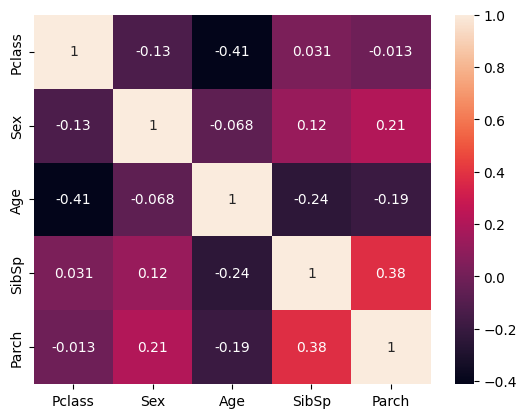

In [26]:
sns.heatmap(tt.drop(["Survived","Name","PassengerId","Fare","Embarked","Cabin", "Cabin_Unknown","Cabin1", "Cabin2", "Cabin3", "Ticket"], axis=1).corr(), annot=True)

In [27]:
# Promeni ovu lambdu funckiju. (!!!)
median_age = tt['Age'].median()
tt['Age'] = tt.groupby(['SibSp', 'Parch', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
tt['Age'].fillna(median_age, inplace=True)

In [28]:
tt.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin1,Cabin2,Cabin3,Cabin_Unknown
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,Unknown,S,0,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,C85,C,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,Unknown,S,0,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,C123,S,0,1,0,0
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,Unknown,S,0,0,0,1


In [29]:
tt['Honorific'] = [name.split(',')[1].split('.')[0].strip() for name in tt['Name']]
tt[['Name', 'Honorific']].head()

,Name,Honorific
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [30]:
tt["Honorific"].value_counts()

Honorific
Mr              751
Miss            256
Mrs             192
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [31]:
rare_honorifics = {}
for honorific in tt["Honorific"]:
    if honorific in rare_honorifics:
        rare_honorifics[honorific] += 1
    else:
        rare_honorifics[honorific] = 1

#Ekstraktovanje honorifika koji sadrze manje od 40 lika
rare_honorifics = [h for h, count in rare_honorifics.items() if count < 40]
print(rare_honorifics)

['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona']


In [32]:
for honorific in rare_honorifics:
    tt["Honorific"].replace([honorific], "Rare_Honorific", inplace=True)

In [33]:
tt[['Honorific', 'Survived']].groupby(['Honorific'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Honorific,Survived
3,Mrs,0.816667
1,Miss,0.707865
0,Master,0.589744
4,Rare_Honorific,0.444444
2,Mr,0.154599


In [34]:
# Extract the numeric part of the ticket
tt['Ticket_Type'] = tt['Ticket'].apply(lambda x: 'Single' if len(x.split()) == 1 else 'Multiple')
tt.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin1,Cabin2,Cabin3,Cabin_Unknown,Honorific,Ticket_Type
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,Unknown,S,0,0,0,1,Mr,Multiple
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,C85,C,0,1,0,0,Mrs,Multiple
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,Unknown,S,0,0,0,1,Miss,Multiple
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,C123,S,0,1,0,0,Mrs,Single
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,Unknown,S,0,0,0,1,Mr,Single


In [35]:
tt[['Ticket_Type', 'Survived']].groupby(['Ticket_Type'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)
#Ticket varijabla deluje kao nebitna, pa cu je izbaciti

,Ticket_Type,Survived
0,Multiple,0.390698
1,Single,0.384848


In [36]:
tt=tt.drop(["Name", "Cabin","Ticket_Type","Ticket"], axis=1)
tt.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin1,Cabin2,Cabin3,Cabin_Unknown,Honorific
0,1,0.0,3,0,22.0,1,0,1.981001,S,0,0,0,1,Mr
1,2,1.0,1,1,38.0,1,0,4.266662,C,0,1,0,0,Mrs
2,3,1.0,3,1,26.0,0,0,2.070022,S,0,0,0,1,Miss
3,4,1.0,1,1,35.0,1,0,3.972177,S,0,1,0,0,Mrs
4,5,0.0,3,0,35.0,0,0,2.085672,S,0,0,0,1,Mr


In [37]:
tt["FamilySize"]=tt["SibSp"]+tt["Parch"]+1
tt[["SibSp","Parch","FamilySize"]].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [38]:
tt[['FamilySize', 'Survived']].groupby('FamilySize', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.550000
6,7,0.333333
0,1,0.300935
4,5,0.200000
5,6,0.150000
7,8,0.000000
8,11,NaN


In [39]:
tt=tt.drop(["SibSp","Parch"], axis=1)
tt.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Cabin1,Cabin2,Cabin3,Cabin_Unknown,Honorific,FamilySize
0,1,0.0,3,0,22.0,1.981001,S,0,0,0,1,Mr,2
1,2,1.0,1,1,38.0,4.266662,C,0,1,0,0,Mrs,2
2,3,1.0,3,1,26.0,2.070022,S,0,0,0,1,Miss,1
3,4,1.0,1,1,35.0,3.972177,S,0,1,0,0,Mrs,2
4,5,0.0,3,0,35.0,2.085672,S,0,0,0,1,Mr,1


In [40]:
tt=pd.get_dummies(tt, columns=["Honorific", "Embarked"])
tt.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin1,Cabin2,Cabin3,Cabin_Unknown,FamilySize,Honorific_Master,Honorific_Miss,Honorific_Mr,Honorific_Mrs,Honorific_Rare_Honorific,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1.981001,0,0,0,1,2,False,False,True,False,False,False,False,True
1,2,1.0,1,1,38.0,4.266662,0,1,0,0,2,False,False,False,True,False,True,False,False
2,3,1.0,3,1,26.0,2.070022,0,0,0,1,1,False,True,False,False,False,False,False,True
3,4,1.0,1,1,35.0,3.972177,0,1,0,0,2,False,False,False,True,False,False,False,True
4,5,0.0,3,0,35.0,2.085672,0,0,0,1,1,False,False,True,False,False,False,False,True


In [41]:
train=tt[:len(train)]
test=tt[len(train):]

In [42]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin1,Cabin2,Cabin3,Cabin_Unknown,FamilySize,Honorific_Master,Honorific_Miss,Honorific_Mr,Honorific_Mrs,Honorific_Rare_Honorific,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1.981001,0,0,0,1,2,False,False,True,False,False,False,False,True
1,2,1.0,1,1,38.0,4.266662,0,1,0,0,2,False,False,False,True,False,True,False,False
2,3,1.0,3,1,26.0,2.070022,0,0,0,1,1,False,True,False,False,False,False,False,True
3,4,1.0,1,1,35.0,3.972177,0,1,0,0,2,False,False,False,True,False,False,False,True
4,5,0.0,3,0,35.0,2.085672,0,0,0,1,1,False,False,True,False,False,False,False,True


In [43]:
test=test.drop("Survived",axis=1)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin1,Cabin2,Cabin3,Cabin_Unknown,FamilySize,Honorific_Master,Honorific_Miss,Honorific_Mr,Honorific_Mrs,Honorific_Rare_Honorific,Embarked_C,Embarked_Q,Embarked_S
875,892,3,0,34.5,2.057860,0,0,0,1,1,False,False,True,False,False,False,True,False
876,893,3,1,47.0,1.945910,0,0,0,1,2,False,False,False,True,False,False,False,True
877,894,2,0,62.0,2.270836,0,0,0,1,1,False,False,True,False,False,False,True,False
878,895,3,0,27.0,2.159003,0,0,0,1,1,False,False,True,False,False,False,False,True
879,896,3,1,22.0,2.508582,0,0,0,1,3,False,False,False,True,False,False,False,True


In [44]:
#modeliranje
X_train=train.drop("Survived",axis=1)
Y_train=train["Survived"]
X_test=test.copy()
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (875, 18)
Y_train shape: (875,)
X_test shape: (418, 18)


In [45]:
X_test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin1,Cabin2,Cabin3,Cabin_Unknown,FamilySize,Honorific_Master,Honorific_Miss,Honorific_Mr,Honorific_Mrs,Honorific_Rare_Honorific,Embarked_C,Embarked_Q,Embarked_S
875,892,3,0,34.5,2.057860,0,0,0,1,1,False,False,True,False,False,False,True,False
876,893,3,1,47.0,1.945910,0,0,0,1,2,False,False,False,True,False,False,False,True
877,894,2,0,62.0,2.270836,0,0,0,1,1,False,False,True,False,False,False,True,False
878,895,3,0,27.0,2.159003,0,0,0,1,1,False,False,True,False,False,False,False,True
879,896,3,1,22.0,2.508582,0,0,0,1,3,False,False,False,True,False,False,False,True


In [46]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin1,Cabin2,Cabin3,Cabin_Unknown,FamilySize,Honorific_Master,Honorific_Miss,Honorific_Mr,Honorific_Mrs,Honorific_Rare_Honorific,Embarked_C,Embarked_Q,Embarked_S
875,892,3,0,34.5,2.057860,0,0,0,1,1,False,False,True,False,False,False,True,False
876,893,3,1,47.0,1.945910,0,0,0,1,2,False,False,False,True,False,False,False,True
877,894,2,0,62.0,2.270836,0,0,0,1,1,False,False,True,False,False,False,True,False
878,895,3,0,27.0,2.159003,0,0,0,1,1,False,False,True,False,False,False,False,True
879,896,3,1,22.0,2.508582,0,0,0,1,3,False,False,False,True,False,False,False,True


In [48]:
from sklearn.linear_model import LogisticRegression
#logisticka regresija
logisticReggresion = LogisticRegression(solver='liblinear')
# Fitujemo krivu
logisticReggresion.fit(X_train,Y_train)

# Iz nekog razloga mi daje float-ove za resenja pa sam ih cast-ovao u integere
Y_pred=logisticReggresion.predict(X_test).astype(int)
acc_log=round(logisticReggresion.score(X_train,Y_train)*100,2)
acc_log

83.77

In [ ]:
""" GORIIIIIIIIIIIII
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test).astype(int)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree"""

In [ ]:
""" GORIIIIIIIIIIIII
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test).astype(int)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian"""

In [ ]:
""" GORIIIIIIIIIIII
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest"""

In [51]:
submit=pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": Y_pred})
submit.head()

,PassengerId,Survived
875,892,0
876,893,1
877,894,0
878,895,0
879,896,1


In [53]:
submit.to_csv("domaci2_titanik.csv", index=False)